# Face Mask Image Classification

### Import relevant libraries and project dependancies

In [188]:
import tensorflow as tf
import numpy as np
import csv
import cv2
import seaborn as sb
import matplotlib.pyplot as plt
import os
import imghdr
import warnings

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

warnings.filterwarnings('ignore')

In [189]:

# configure how the library handles GPU memory allocation. 

gpus = tf.config.experimental.list_physical_devices('GPU')

for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# When 'set_memory_growth' is set to True, TensorFlow will not allocate all available GPU memory upfront 
# but will grow the memory usage as needed by the application. This can be useful to avoid out-of-memory errors and 
#to allow multiple processes to share the same GPU.

### Data preparations

In [190]:
data_dir='..\data'
# os.listdir(data_dir)

file_ext = ['.jpeg', '.jpg', '.png', '.bitmap', '.gif']

classes = os.listdir(data_dir)
classes

['face mask', 'no mask']

In [191]:
for image_path in os.listdir(data_dir):
    for i, img in enumerate(os.listdir(os.path.join(data_dir, image_path))):
        # print(img)
        try:
            image = cv2.imread(img)
            tip = imghdr.what(img)
            if tip not in file_ext:
                print(f'Unsupported File Format: {img}')
        except Exception as e:
            print(f'Image File Extension Passed: {img}')
        break

Image File Extension Passed: -1x-1.jpg
Image File Extension Passed: -collection-many-young-people-faces-collage-multiracial-millennial-208614913.jpg


### Data Initialization

In [192]:
keras_data = tf.keras.utils.image_dataset_from_directory(data_dir)

keras_data = keras_data.map(lambda x, y:(x/255, y))

batch = keras_data.as_numpy_iterator().next()

Found 2863 files belonging to 2 classes.


In [193]:
batch[0][1]

array([[[0.4989967 , 0.49966317, 0.4696235 ],
        [0.5107296 , 0.50578254, 0.45345327],
        [0.53967613, 0.52117753, 0.45675552],
        ...,
        [0.46780792, 0.51094514, 0.48741576],
        [0.4627451 , 0.49856004, 0.4860141 ],
        [0.47274825, 0.5080424 , 0.49627766]],

       [[0.57357454, 0.54448444, 0.51393145],
        [0.57208264, 0.54691416, 0.500154  ],
        [0.5481464 , 0.51987594, 0.45958945],
        ...,
        [0.47218004, 0.5153173 , 0.49342695],
        [0.46736124, 0.5031762 , 0.49073908],
        [0.4801167 , 0.5154108 , 0.5036461 ]],

       [[0.56076086, 0.52421826, 0.48892418],
        [0.55749714, 0.5314708 , 0.48513958],
        [0.5278546 , 0.5079251 , 0.45864737],
        ...,
        [0.4540725 , 0.49453667, 0.4868697 ],
        [0.49290884, 0.53104186, 0.5245404 ],
        [0.4725729 , 0.5105401 , 0.5041216 ]],

       ...,

       [[0.45898935, 0.3085541 , 0.21928346],
        [0.46425575, 0.301098  , 0.12665483],
        [0.9731586 , 0

In [194]:
batch[1]

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1,
       1, 0, 1, 0, 0, 1, 0, 1, 1, 0])

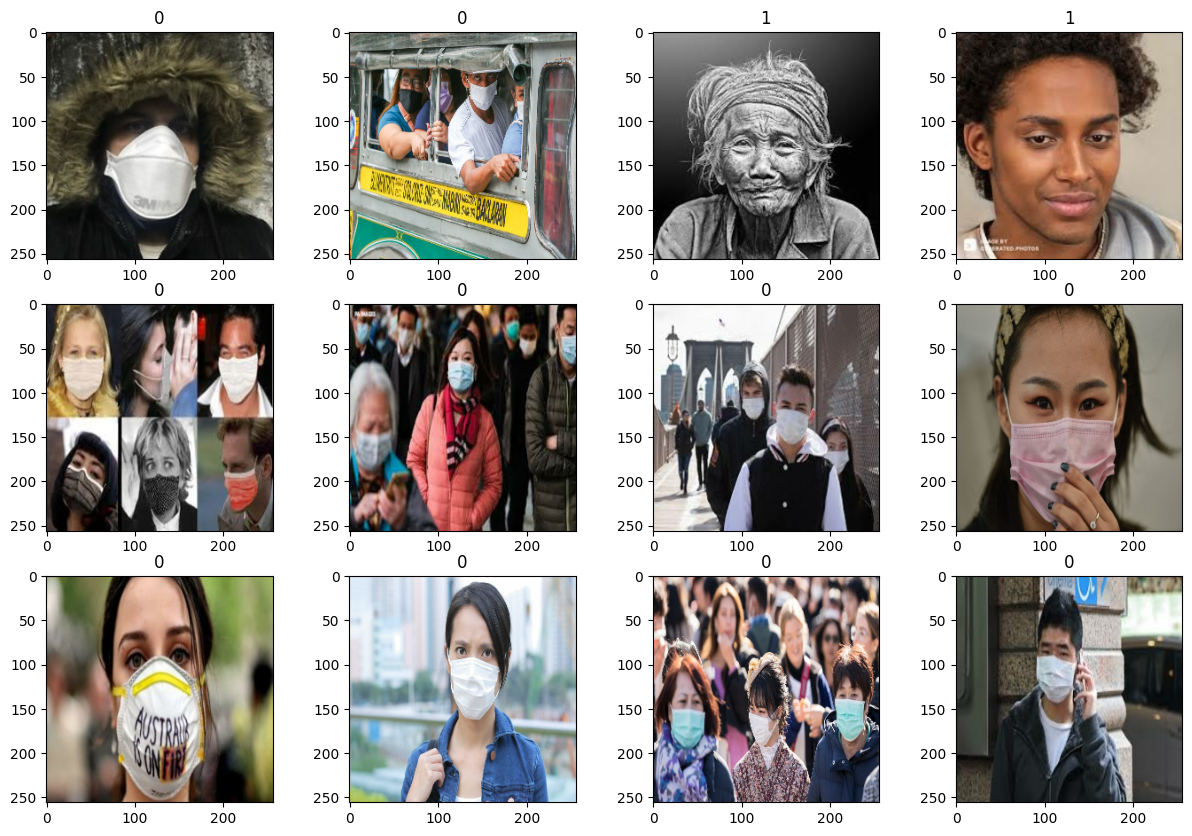

In [195]:
fig, ax = plt.subplots(nrows=3, ncols=4, figsize=(15, 10))
ax = ax.flatten()
for idx, img in enumerate(batch[0][:12]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

### Split the Dataset

In [196]:
len(keras_data)

90

In [197]:
train_size = int(len(keras_data) * .7)
val_size = int(len(keras_data) * .2) 
test_size = int(len(keras_data) * .1) + 1

In [198]:
print('Train size:', train_size)
print('Validation', val_size)
print('Test size:', test_size)

Train size: 62
Validation 18
Test size: 10


In [199]:
train_size+val_size+test_size

90

In [200]:
train = keras_data.take(train_size)
val = keras_data.skip(train_size).take(val_size)
test = keras_data.skip(train_size + val_size).take(test_size)

### Build Neural Network Model

In [201]:
model = Sequential()

In [202]:
model.add(Conv2D(filters=16, kernel_size=(3,3), strides=1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(filters=32, kernel_size=(3,3), strides=1))
model.add(MaxPooling2D())

model.add(Conv2D(filters=16, kernel_size=(3,3), strides=1, activation='relu', input_shape=(256,256,3)))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(units=256, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

In [203]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 254, 254, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_9 (MaxPooling2D)       │ (None, 127, 127, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 125, 125, 32)        │           4,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 62, 62, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 60, 60, 16)          │           4,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 30, 30, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 14400)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │       3,686,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,696,625 (14.10 MB)

 Trainable params: 3,696,625 (14.10 MB)

 Non-trainable params: 0 (0.00 B)

In [204]:
model.compile(optimizer='adam', loss=tf.losses.binary_crossentropy, metrics=['accuracy'])

### Model Training

In [205]:
logs = '..\logs'

tensorboards_callback = tf.keras.callbacks.TensorBoard(logs)

In [206]:
def is_image_file(file_path):
    valid_extensions = ['.jpg', '.jpeg', '.png', '.gif', '.bmp']
    return any(file_path.lower().endswith(ext) for ext in valid_extensions)

def check_images_in_directory(directory):
    for root, _, files in os.walk(directory):
        for file in files:
            file_path = os.path.join(root, file)
            if not is_image_file(file_path):
                print(f"Unsupported image file format: {file_path}")
            else:
                try:
                    image = tf.io.read_file(file_path)
                    tf.image.decode_image(image, channels=3)
                except tf.errors.InvalidArgumentError:
                    print(f"Invalid image format for file: {file_path}")
                # os.remove(file_path)
                    

# Path to the directory containing images
directory_path = data_dir

# Check images in the directory
check_images_in_directory(directory_path)

In [207]:
history = model.fit(train, epochs=10, validation_data=val, callbacks=tensorboards_callback)

Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 135s 1s/step - accuracy: 0.5820 - loss: 0.8903 - val_accuracy: 0.6736 - val_loss: 0.6048
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.7107 - loss: 0.5673 - val_accuracy: 0.7066 - val_loss: 0.5703
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.7560 - loss: 0.5071 - val_accuracy: 0.6146 - val_loss: 0.6715
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 89s 1s/step - accuracy: 0.7570 - loss: 0.5014 - val_accuracy: 0.6858 - val_loss: 0.5921
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 88s 1s/step - accuracy: 0.8144 - loss: 0.4359 - val_accuracy: 0.7188 - val_loss: 0.5554
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.8724 - loss: 0.3255 - val_accuracy: 0.7205 - val_loss: 0.7286
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 86s 1s/step - accuracy: 0.9133 - loss: 0.2286 - val_accuracy: 0.7083 - val_loss: 0.7324
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 87s 1s/step - accuracy: 0.9580 - loss: 0.1349 - val_accuracy: 0.7431 - val_loss

In [208]:
history.history

{'accuracy': [0.6325604915618896,
  0.7202621102333069,
  0.7560483813285828,
  0.7605846524238586,
  0.8155242204666138,
  0.8603830933570862,
  0.9022177457809448,
  0.946068525314331,
  0.9627016186714172,
  0.9778226017951965],
 'loss': [0.7127436399459839,
  0.5577294230461121,
  0.5119971632957458,
  0.4937092363834381,
  0.42102497816085815,
  0.33055585622787476,
  0.2460561841726303,
  0.15142527222633362,
  0.11036526411771774,
  0.07467157393693924],
 'val_accuracy': [0.6736111044883728,
  0.7065972089767456,
  0.6145833134651184,
  0.6857638955116272,
  0.71875,
  0.7204861044883728,
  0.7083333134651184,
  0.7430555820465088,
  0.7239583134651184,
  0.7673611044883728],
 'val_loss': [0.6048166751861572,
  0.5702863931655884,
  0.671484112739563,
  0.5921351909637451,
  0.5553795695304871,
  0.7285698652267456,
  0.7323911190032959,
  0.819782555103302,
  0.775762677192688,
  0.9101006388664246]}

### Visualize the performance

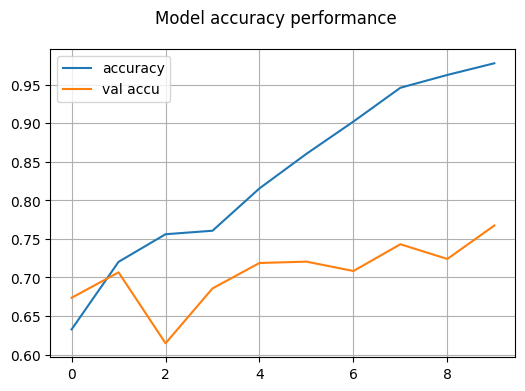

In [209]:
plt.figure(figsize=(6, 4))
sb.lineplot(history.history['accuracy'], label='accuracy')
sb.lineplot(history.history['val_accuracy'], label='val accu')
plt.legend(loc='upper left')
plt.grid()
plt.suptitle('Model accuracy performance')
plt.show()

Text(0.5, 0.98, 'Model loss performance')

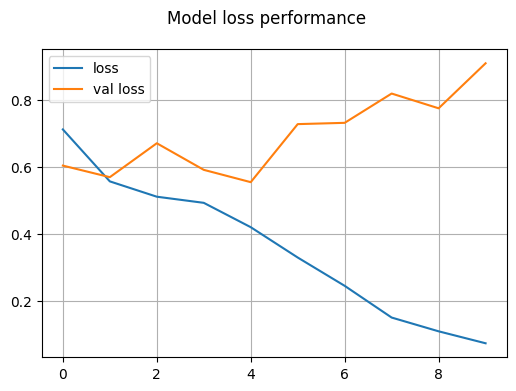

In [210]:
plt.figure(figsize=(6, 4))
sb.lineplot(history.history['loss'], label='loss')
sb.lineplot(history.history['val_loss'], label='val loss')
plt.legend(loc='upper left')
plt.grid()
plt.suptitle('Model loss performance')

### Evaluate the model

In [211]:
prec = Precision()
rec = Recall()
bin_acc = BinaryAccuracy()

In [212]:
for batch in test.as_numpy_iterator():
    x, y = batch
    y_pred = model.predict(x)
    prec.update_state(y, y_pred)
    rec.update_state(y, y_pred)
    bin_acc.update_state(y, y_pred)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 535ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 186ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step


In [213]:
print(f'Precision Score: {round(prec.result().numpy(), 2)}, Recall Score: {rec.result().numpy()}, Binary Accuracy Score: {bin_acc.result().numpy()}')

Precision Score: 0.6499999761581421, Recall Score: 0.6137930750846863, Binary Accuracy Score: 0.6567656993865967


### Manual testing

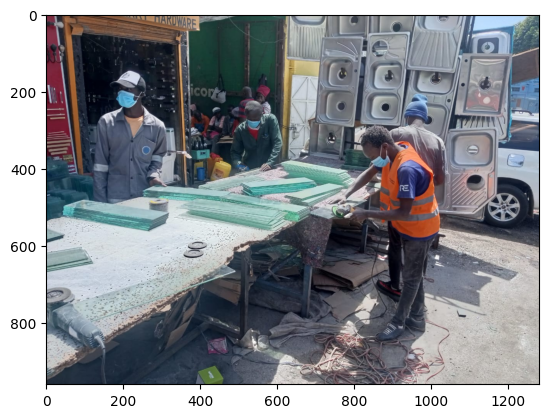

In [214]:
img_file = cv2.imread(r"D:\Downloads\image3.jpg")
plt.imshow(cv2.cvtColor(img_file, cv2.COLOR_RGB2BGR))

In [215]:
img_resize = tf.image.resize(img_file, (256, 256))

In [216]:
new_prediction = model.predict(np.expand_dims(img_resize/255, 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


In [217]:
new_prediction

array([[0.00116579]], dtype=float32)

In [218]:
if new_prediction > 0.5:
    print(f'Masked Face')
else:
    print(f'No mask')

No mask
